https://medium.com/@jonathan_hui/rl-trust-region-policy-optimization-trpo-explained-a6ee04eeeee9
https://stackoverflow.com/a/50663200

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
train_env = gym.make('LunarLander-v2')
test_env = gym.make('LunarLander-v2')

In [3]:
SEED = 1234

# train_env.seed(SEED);
# test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [4]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()
        
        self.net = nn.Sequential(
            layer_init(nn.Linear(input_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, output_dim))
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [6]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [10]:
LEARNING_RATE = 0.0002

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [11]:
def train(env, policy, optimizer, discount_factor, ppo_steps, ppo_clip, norm_returns = False, norm_advantages = True):

    max_steps = 256
    policy.train()

    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0
    count = 0

    state, _ = env.reset(seed=SEED)

    while not done and count < max_steps:

        state = torch.FloatTensor(state).unsqueeze(0)

        #append state here, not after we get the next state from env.step()
        states.append(state)
        
        action_pred, value_pred = policy(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _, _ = env.step(action.item())

        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        
        episode_reward += reward
        count += 1
    
    states = torch.cat(states)
    actions = torch.cat(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)

    returns = calculate_returns(rewards, discount_factor, normalize=norm_returns)
    advantages = calculate_advantages(returns, values, normalize=norm_advantages)

    policy_loss, value_loss = update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip)

    return policy_loss, value_loss, episode_reward

In [12]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns

def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [13]:
def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [14]:
def update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip):
    
    total_policy_loss = 0 
    total_value_loss = 0
    
    states = states.detach()
    actions = actions.detach()
    log_prob_actions = log_prob_actions.detach()
    advantages = advantages.detach()
    returns = returns.detach()
    
    for _ in range(ppo_steps):
                
        #get new log prob of actions for all input states
        action_pred, value_pred = policy(states)
        value_pred = value_pred.squeeze(-1)
        dist = distributions.Categorical(logits=action_pred)
        
        #new log prob using old actions
        new_log_prob_actions = dist.log_prob(actions)
        
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
                
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).mean()
        
        value_loss = F.smooth_l1_loss(returns, value_pred).mean()
    
        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
    
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [15]:
def evaluate(env, policy):

    max_steps = 256
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state, _ = env.reset(seed=SEED+1)

    count = 0
    while not done and count < max_steps:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():

            action_pred, _ = policy(state)

            dist = distributions.Categorical(logits=action_pred)
        
            action = dist.sample()
                
        state, reward, done, _, _ = env.step(action.item())

        episode_reward += reward
        count += 1
    return episode_reward

In [16]:
from tqdm import tqdm

MAX_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10
PPO_STEPS = 5
PPO_CLIP = 0.2

bar = tqdm(np.arange(MAX_EPISODES))
train_rewards = []
test_rewards = []

for episode in bar:
    
    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP, norm_returns=False, norm_advantages=True)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
        
        print(f'| Episode: {episode:3} | PL {policy_loss} | Train: {mean_train_rewards:7.1f} | Test: {mean_test_rewards:7.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break


  0%|                       | 0/1000 [00:00<?, ?it/s]/Users/shyam/anaconda3/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  1%|               | 6/1000 [00:00<00:39, 25.37it/s]

| Episode:   0 | PL -0.013191865504300376 | Train:  -347.6 | Test:  -129.8 |


  1%|▏             | 14/1000 [00:00<00:33, 29.56it/s]

| Episode:  10 | PL -0.0008761923827216237 | Train:  -294.9 | Test:  -247.7 |


  3%|▎             | 26/1000 [00:00<00:30, 32.06it/s]

| Episode:  20 | PL -0.0010450404715251077 | Train:  -328.6 | Test:  -306.8 |


  4%|▌             | 38/1000 [00:01<00:28, 33.87it/s]

| Episode:  30 | PL -0.002180951429614322 | Train:  -363.1 | Test:  -349.2 |


  5%|▋             | 46/1000 [00:01<00:28, 33.95it/s]

| Episode:  40 | PL -0.001188467819527727 | Train:  -343.3 | Test:  -341.4 |


  5%|▊             | 54/1000 [00:01<00:27, 34.30it/s]

| Episode:  50 | PL -0.0007312963525883251 | Train:  -298.5 | Test:  -329.1 |


  7%|▉             | 66/1000 [00:02<00:28, 32.21it/s]

| Episode:  60 | PL -0.004001933272947519 | Train:  -276.7 | Test:  -334.4 |


  8%|█             | 78/1000 [00:02<00:26, 34.58it/s]

| Episode:  70 | PL -0.004682942332364025 | Train:  -237.7 | Test:  -303.3 |


  9%|█▏            | 86/1000 [00:02<00:25, 35.68it/s]

| Episode:  80 | PL -0.0015811083450529366 | Train:  -189.7 | Test:  -246.4 |


 10%|█▎            | 98/1000 [00:02<00:25, 35.89it/s]

| Episode:  90 | PL -0.0008801513200052145 | Train:  -186.2 | Test:  -238.4 |


 11%|█▍           | 106/1000 [00:03<00:24, 36.93it/s]

| Episode: 100 | PL -0.0024043275814861704 | Train:  -180.0 | Test:  -246.9 |


 12%|█▌           | 118/1000 [00:03<00:24, 36.37it/s]

| Episode: 110 | PL -0.005316754004621269 | Train:  -184.0 | Test:  -239.2 |


 13%|█▋           | 126/1000 [00:03<00:23, 36.44it/s]

| Episode: 120 | PL -0.0055162153040146465 | Train:  -150.8 | Test:  -197.5 |


 14%|█▊           | 138/1000 [00:04<00:23, 37.00it/s]

| Episode: 130 | PL -0.0021854701651404045 | Train:  -147.4 | Test:  -177.7 |


 15%|█▉           | 146/1000 [00:04<00:23, 35.76it/s]

| Episode: 140 | PL -0.002333142730322416 | Train:  -149.5 | Test:  -162.0 |


 15%|██           | 154/1000 [00:04<00:24, 34.65it/s]

| Episode: 150 | PL -0.0014669198445045352 | Train:  -136.9 | Test:  -135.9 |


 17%|██▏          | 166/1000 [00:04<00:24, 33.49it/s]

| Episode: 160 | PL -0.004801528515305325 | Train:  -121.8 | Test:  -129.6 |


 17%|██▎          | 174/1000 [00:05<00:25, 32.43it/s]

| Episode: 170 | PL -0.0004024234045927619 | Train:  -135.8 | Test:  -125.0 |


 19%|██▍          | 186/1000 [00:05<00:26, 30.52it/s]

| Episode: 180 | PL 0.0022419541312597773 | Train:  -134.7 | Test:  -107.8 |


 19%|██▌          | 193/1000 [00:05<00:30, 26.12it/s]

| Episode: 190 | PL -0.0030939750924772157 | Train:   -97.7 | Test:  -101.6 |


 20%|██▋          | 202/1000 [00:06<00:39, 20.19it/s]

| Episode: 200 | PL -0.0008386150993578056 | Train:   -66.4 | Test:   -84.4 |


 21%|██▊          | 213/1000 [00:07<00:56, 13.99it/s]

| Episode: 210 | PL -0.0008504500461585559 | Train:   -73.9 | Test:   -77.6 |


 22%|██▉          | 223/1000 [00:07<00:58, 13.25it/s]

| Episode: 220 | PL -0.0031487565918302102 | Train:   -94.9 | Test:  -133.5 |


 23%|███          | 233/1000 [00:08<01:06, 11.57it/s]

| Episode: 230 | PL -0.001547362060775302 | Train:   -84.8 | Test:  -165.6 |


 24%|███▏         | 243/1000 [00:09<00:59, 12.72it/s]

| Episode: 240 | PL -0.0007638390900796205 | Train:   -62.3 | Test:  -111.9 |


 25%|███▎         | 253/1000 [00:10<00:50, 14.75it/s]

| Episode: 250 | PL -0.0011916578983930163 | Train:   -59.2 | Test:   -68.2 |


 26%|███▍         | 263/1000 [00:10<00:57, 12.86it/s]

| Episode: 260 | PL -0.0019108209936280582 | Train:   -52.9 | Test:   -60.1 |


 27%|███▌         | 273/1000 [00:11<00:53, 13.49it/s]

| Episode: 270 | PL -0.0023199896702844136 | Train:   -48.4 | Test:   -77.6 |


 28%|███▋         | 283/1000 [00:12<01:03, 11.38it/s]

| Episode: 280 | PL -0.0006676988936224189 | Train:   -59.7 | Test:  -106.5 |


 29%|███▊         | 293/1000 [00:13<00:58, 12.08it/s]

| Episode: 290 | PL -0.00048307759853966433 | Train:   -61.6 | Test:  -116.9 |


 30%|███▉         | 303/1000 [00:13<00:38, 18.25it/s]

| Episode: 300 | PL -0.006189304175774064 | Train:   -61.7 | Test:  -102.1 |


 31%|████         | 313/1000 [00:14<00:41, 16.69it/s]

| Episode: 310 | PL -0.0023935570859334636 | Train:   -69.8 | Test:   -71.9 |


 32%|████▏        | 325/1000 [00:15<00:29, 22.95it/s]

| Episode: 320 | PL -0.001299486464360354 | Train:   -64.0 | Test:   -78.3 |


 33%|████▎        | 334/1000 [00:15<00:34, 19.25it/s]

| Episode: 330 | PL -0.0046633950993955125 | Train:   -45.9 | Test:   -63.7 |


 34%|████▍        | 344/1000 [00:16<00:43, 15.14it/s]

| Episode: 340 | PL -0.004266152044905724 | Train:    -4.2 | Test:   -45.3 |


 35%|████▌        | 352/1000 [00:16<00:49, 13.21it/s]

| Episode: 350 | PL -0.00023225287083664028 | Train:     4.0 | Test:   -41.2 |


 36%|████▋        | 362/1000 [00:17<01:07,  9.42it/s]

| Episode: 360 | PL -0.0018208278763347445 | Train:    -3.6 | Test:   -52.3 |


 37%|████▊        | 373/1000 [00:18<00:55, 11.32it/s]

| Episode: 370 | PL -0.000494429497279438 | Train:     1.4 | Test:   -30.2 |


 38%|████▉        | 383/1000 [00:19<00:58, 10.63it/s]

| Episode: 380 | PL -0.00017079868651141228 | Train:    23.2 | Test:   -19.1 |


 39%|█████        | 393/1000 [00:20<00:57, 10.48it/s]

| Episode: 390 | PL -0.001756786676174358 | Train:    42.8 | Test:   -12.5 |


 40%|█████▏       | 403/1000 [00:21<00:50, 11.82it/s]

| Episode: 400 | PL -0.0032022959683874557 | Train:    17.9 | Test:   -34.4 |


 41%|█████▎       | 413/1000 [00:22<00:37, 15.49it/s]

| Episode: 410 | PL -0.0010705059660682554 | Train:     7.3 | Test:   -40.4 |


 42%|█████▍       | 423/1000 [00:23<00:50, 11.45it/s]

| Episode: 420 | PL -0.0028785984507550045 | Train:     6.4 | Test:   -37.9 |


 43%|█████▋       | 433/1000 [00:24<00:57,  9.90it/s]

| Episode: 430 | PL -0.002661215924679523 | Train:    40.8 | Test:     7.3 |


 44%|█████▊       | 443/1000 [00:25<00:46, 11.93it/s]

| Episode: 440 | PL -8.660188781165548e-05 | Train:    42.0 | Test:    44.5 |


 45%|█████▉       | 452/1000 [00:26<01:05,  8.43it/s]

| Episode: 450 | PL -0.0009395897794975304 | Train:    38.6 | Test:    54.9 |


 46%|██████       | 462/1000 [00:27<00:57,  9.42it/s]

| Episode: 460 | PL -0.004129817992475254 | Train:    35.0 | Test:    61.3 |


 47%|██████▏      | 473/1000 [00:28<00:47, 11.01it/s]

| Episode: 470 | PL -0.0008109549187704454 | Train:    50.2 | Test:    52.3 |


 48%|██████▎      | 481/1000 [00:29<00:51, 10.02it/s]

| Episode: 480 | PL -0.001209645802382872 | Train:    36.0 | Test:    15.8 |


 49%|██████▍      | 492/1000 [00:30<01:05,  7.75it/s]

| Episode: 490 | PL -0.0011767027128907787 | Train:    21.7 | Test:   -23.9 |


 50%|██████▌      | 501/1000 [00:31<01:00,  8.27it/s]

| Episode: 500 | PL -0.001707790711982645 | Train:     3.8 | Test:   -25.6 |


 51%|██████▋      | 512/1000 [00:33<01:00,  8.07it/s]

| Episode: 510 | PL -0.003017423499563699 | Train:   -41.5 | Test:    -0.2 |


 52%|██████▊      | 522/1000 [00:34<01:01,  7.74it/s]

| Episode: 520 | PL 0.001066238861243669 | Train:   -21.4 | Test:    20.1 |


 53%|██████▉      | 532/1000 [00:35<01:13,  6.34it/s]

| Episode: 530 | PL 3.9736382373375e-05 | Train:    -1.2 | Test:    43.3 |


 54%|███████      | 542/1000 [00:37<01:05,  6.99it/s]

| Episode: 540 | PL -0.0012654560131029732 | Train:    50.0 | Test:    46.8 |


 55%|███████▏     | 552/1000 [00:38<00:58,  7.70it/s]

| Episode: 550 | PL -0.001213576380029389 | Train:    69.2 | Test:    67.3 |


 55%|███████▏     | 553/1000 [00:39<00:31, 14.16it/s]


KeyboardInterrupt: 

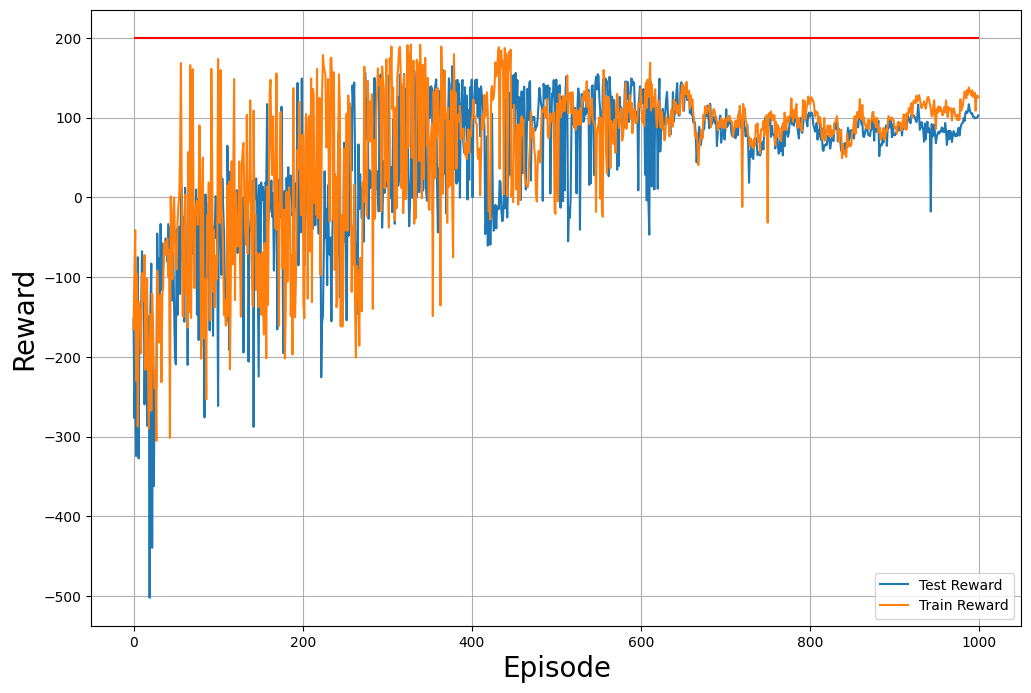

In [16]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()